In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

['BE3_31', 'BD1_11', 'LS_VEG1', 'tobacco', 'L_BR_FQ', 'L_OUT_FQ']

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic' # 예시: 맑은 고딕으로 설정 (Windows 환경 시)
plt.rcParams['axes.unicode_minus'] = False

In [4]:
df = pd.read_csv("건강데이터_2022_2023_합본.csv")

In [5]:
df = df[(df['HE_glu'] >= 50) & (df['HE_glu'] <= 400)]

전처리 

In [6]:
df['BE3_31'] = df['BE3_31'].astype(str).str.strip().replace({ #	1주일간 걷기 일수
'1.0' : 0,
'2.0' : 1,
'3.0' : 2,
'4.0' : 3,
'5.0' : 4,
'6.0' : 5,
'7.0' : 6,
'8.0' : 7,
'88.0' : 0,
'99.0' : np.nan,
'nan' : np.nan
 })
df['BE3_31'] = pd.to_numeric(df['BE3_31'], errors='coerce')

In [7]:
df['LS_VEG1'] = df['LS_VEG1'].astype(str).str.strip().replace({  #최근 1년 동안 평균 채소류(김치 및 장아찌 제외), 버섯류, 해조류 섭취 빈도
'1.0' : 1095, #1.0이 1년 동안 채소 섭취가 하루 3회 이상이므로 365 * 3
'2.0' : 730,  #2.0이 1년 동안 채소 섭취가 하루 2회이므로 365 * 2
'3.0' : 365,  #3.0이 1년 동안 채소 섭취가 하루 1회이므로 365 * 1
'4.0' : 286,  #주 5-6회
'5.0' : 156,  #주 2-4회
'6.0' : 52,   #주 1회
'7.0' : 30,   
'8.0' : 12,
'9.0' : 6,
'99.0': np.nan,
'nan' : np.nan
})
df['LS_VEG1'] = pd.to_numeric(df['LS_VEG1'], errors='coerce')

In [8]:
# 일반 담배 하루 평균 흡연량 처리
df['BS3_2'] = df['BS3_2'].replace(888, 0)

# 전자 담배 하루 평균 흡연량 처리
df['BS12_47_1'] = df['BS12_47_1'].replace({888: 0, 999: np.nan}) 

# 합치기 전 숫자형으로 변환
df['BS3_2'] = pd.to_numeric(df['BS3_2'], errors='coerce')
df['BS12_47_1'] = pd.to_numeric(df['BS12_47_1'], errors='coerce')

# 두 변수 합산 (NaN은 무시하고 합함)
df['tobacco'] = df[['BS3_2', 'BS12_47_1']].sum(axis=1, skipna=True)

df['tobacco'] = df['tobacco'].astype(str).str.strip().replace({  
'999.0': np.nan,
})

df['tobacco'] = pd.to_numeric(df['tobacco'], errors='coerce')

In [9]:
df['BD1_11'] = df['BD1_11'].astype(str).str.strip().replace({ #1년간 음주빈도
'1.0' : 0,
'2.0' : 6,
'3.0' : 12,
'4.0' : 42,
'5.0' : 130,
'6.0' : 286,
'8.0' : 0,
'9.0' : np.nan,
'nan' : np.nan
})
df['BD1_11'] = pd.to_numeric(df['BD1_11'], errors='coerce')

In [10]:
df['L_BR_FQ'] = df['L_BR_FQ'].astype(str).str.strip().replace({
'1.0' : 6,
'2.0' : 3.5,
'3.0' : 1.5,
'4.0' : 0,
'9.0' : np.nan,
'nan' : np.nan
 })
df['L_BR_FQ'] = pd.to_numeric(df['L_BR_FQ'], errors='coerce')

In [11]:
df['L_OUT_FQ'] = df['L_OUT_FQ'].astype(str).str.strip().replace({ 
'1.0' : 730,
'2.0' : 365,
'3.0' : 286,
'4.0' : 182,
'5.0' : 78,
'6.0' : 24,
'7.0' : 6,
'9.0' : np.nan,
'nan' : np.nan
 })
df['L_OUT_FQ'] = pd.to_numeric(df['L_OUT_FQ'], errors='coerce')

In [12]:
import pandas as pd #고혈압 파생변수 

def classify_bp(row):
    sbp = row['HE_sbp1']
    dbp = row['HE_dbp1']

    if sbp >= 140 or dbp >= 90:
        return '4'
    elif 130 <= sbp <= 139 or 80 <= dbp <= 89:
        return '3'
    elif 120 <= sbp <= 129 and dbp < 80:
        return '2'
    elif 0<=sbp<120 and dbp < 80:
        return '1'

# 데이터프레임에 새로운 열 추가
df['HE_HP2'] = df.apply(classify_bp, axis=1)
df['HE_HP2'] = pd.to_numeric(df['HE_HP2'], errors='coerce')


import pandas as pd #당뇨 파생변수 

def classify_bp(row):
    glu = row['HE_glu']

    if glu <= 99:
        return '1'
    elif 100 <= glu <= 125:
        return '2'
    else:
        return '3'
    

# 데이터프레임에 새로운 열 추가
df['HE_DM_HbA1c2'] = df.apply(classify_bp, axis=1)
df['HE_DM_HbA1c2'] = pd.to_numeric(df['HE_DM_HbA1c2'], errors='coerce')


import pandas as pd #비만 파생변수 

def classify_bp(row):
    bmi = row['HE_BMI']

    if bmi <= 18.5:
        return '1'
    elif 18.5 < bmi <= 22.9:
        return '2'
    elif 22.9 < bmi <= 24.9:
        return '3'
    elif 24.9 < bmi <= 29.9:
        return '4'
    elif 29.9 < bmi <= 34.9:
        return '5'
    else:
        return '6'
    

# 데이터프레임에 새로운 열 추가
df['HE_obe2'] = df.apply(classify_bp, axis=1)
df['HE_obe2'] = pd.to_numeric(df['HE_obe2'], errors='coerce')

Silhouette Score: 0.3627


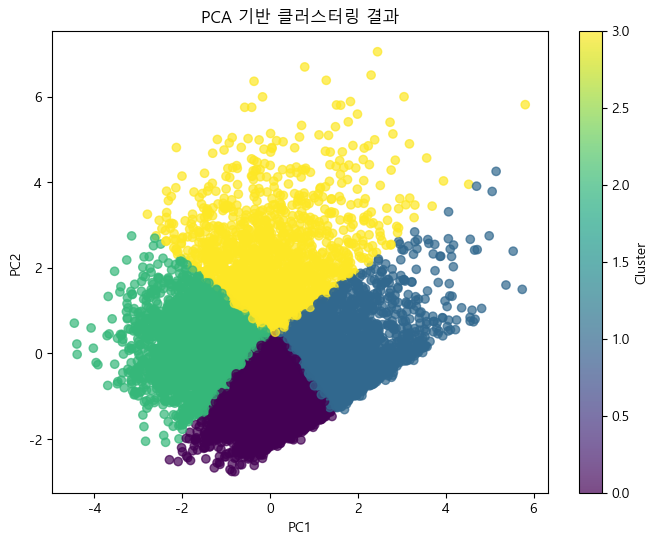

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 사용할 feature 선택
features = ['BE3_31', 'BD1_11', 'LS_VEG1', 'tobacco', 'L_BR_FQ', 'L_OUT_FQ', 'HE_sbp1', 'HE_dbp1']

# 결측치 제거 
df_dropna = df[features].dropna()

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_dropna)

# PCA로 2차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# KMeans 클러스터링 (예: 클러스터 3개)
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_pca)

# 실루엣 점수 확인
score = silhouette_score(X_pca, labels)
print(f"Silhouette Score: {score:.4f}")

# 시각화
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title('PCA 기반 클러스터링 결과')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()


Explained Variance Ratio (PC1, PC2): [0.26103475 0.20237019]
Total Explained Variance: 0.4634
Silhouette Score: 0.3504

Cluster Characteristics (Mean Values):
           BE3_31      BD1_11     LS_VEG1    tobacco    L_OUT_FQ     HE_sbp1  \
Cluster                                                                        
0        4.366111   12.893827  949.508132   0.172707   96.183118  120.396466   
1        2.937269   17.468167  740.078581   0.471534  243.588859  105.114092   
2        3.521073   80.717402  716.179675   5.215736  283.087435  119.248585   
3        4.377732   36.928641  960.195437   0.590597   98.006938  143.455812   
4        3.200546  189.328467  776.446727  14.239316  290.795892  132.866584   

           HE_dbp1  
Cluster             
0        72.861679  
1        64.720750  
2        76.087494  
3        86.118636  
4        84.947631  

Number of Data Points per Cluster:
Cluster
0    3704
1    3133
2    1990
3    2091
4     824
Name: count, dtype: int64


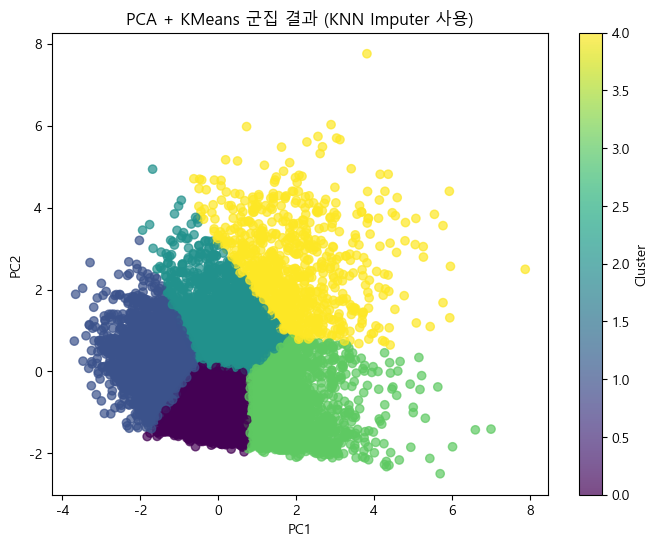

In [17]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 사용할 feature 선택
features = ['BE3_31', 'BD1_11', 'LS_VEG1', 'tobacco', 'L_OUT_FQ', 'HE_sbp1', 'HE_dbp1']
X = df[features]

# 1. 결측치 대체: KNNImputer 사용
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)
X_imputed_df = pd.DataFrame(X_imputed, columns=features, index=df.index)

# 2. 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 3. PCA 차원 축소 (2차원)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio (PC1, PC2): {explained_variance_ratio}")
print(f"Total Explained Variance: {sum(explained_variance_ratio):.4f}")

# 4. 클러스터링 (4개 군집)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_pca)

# 5. 실루엣 점수 확인
score = silhouette_score(X_pca, labels)
print(f"Silhouette Score: {score:.4f}")

# 6. 클러스터 라벨을 원본 데이터에 추가
df_with_clusters = df.copy()
df_with_clusters['Cluster'] = labels

# 7. 군집별 특징 분석 (평균값 계산)
cluster_characteristics = df_with_clusters.groupby('Cluster')[features].mean()
print("\nCluster Characteristics (Mean Values):")
print(cluster_characteristics)

# 8. 군집별 데이터 포인트 수 확인
cluster_counts = df_with_clusters['Cluster'].value_counts().sort_index()
print("\nNumber of Data Points per Cluster:")
print(cluster_counts)

# 9. 시각화
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title('PCA + KMeans 군집 결과 (KNN Imputer 사용)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

In [55]:
from scipy.stats import f_oneway

# 각 feature에 대해 ANOVA 수행
anova_results = {}

for feature in features:
    groups = [group[feature].dropna() for name, group in df_with_clusters.groupby('Cluster')]
    
    # 군집 수가 2개 이상이고, 각 그룹에 데이터가 2개 이상 있어야 함
    if len(groups) >= 2 and all(len(g) > 1 for g in groups):
        f_stat, p_val = f_oneway(*groups)
        anova_results[feature] = {
            'F-statistic': f_stat,
            'p-value': p_val,
            'significant': p_val < 0.05
        }
    else:
        anova_results[feature] = {
            'F-statistic': None,
            'p-value': None,
            'significant': False,
            'note': '그룹 수 부족 또는 데이터 부족'
        }

# 결과 출력
anova_df = pd.DataFrame(anova_results).T
print("\n🔍 ANOVA 결과 (클러스터 간 평균 차이 유의성):")
print(anova_df.sort_values(by='p-value'))



🔍 ANOVA 결과 (클러스터 간 평균 차이 유의성):
          F-statistic p-value significant
BD1_11     1432.37958     0.0        True
LS_VEG1   2418.870474     0.0        True
tobacco   1090.209338     0.0        True
L_BR_FQ   5434.633331     0.0        True
L_OUT_FQ   717.331226     0.0        True
HE_sbp1   3789.161575     0.0        True
HE_dbp1   3500.533152     0.0        True
BE3_31     103.209461     0.0        True


Explained Variance Ratio (PC1, PC2): [0.25247812 0.1850313 ]
Total Explained Variance: 0.4375
Silhouette Score: 0.4990

Cluster Characteristics (Mean Values):
           BE3_31      BD1_11     LS_VEG1    tobacco   L_BR_FQ    L_OUT_FQ  \
Cluster                                                                      
0        4.360430   18.438361  977.971952   0.297447  5.850017  118.761841   
1        3.460742   28.138854  638.316082   0.649583  1.993562  240.059328   
2        3.561033  146.800469  655.004695  13.468310  1.511737  301.269953   
3        4.305641  149.013333  973.761026   9.660513  5.676410  167.514872   

             HE_glu  
Cluster              
0        100.367988  
1         93.428932  
2        101.657277  
3        128.509744  

Number of Data Points per Cluster:
Cluster
0    5954
1    3961
2     852
3     975
Name: count, dtype: int64


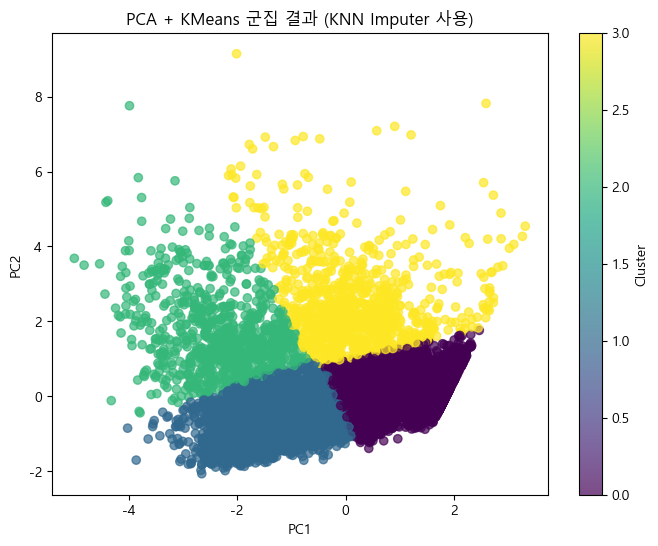

In [56]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 사용할 feature 선택
features = ['BE3_31', 'BD1_11', 'LS_VEG1', 'tobacco', 'L_BR_FQ', 'L_OUT_FQ', 'HE_glu']
X = df[features]

# 1. 결측치 대체: KNNImputer 사용
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)
X_imputed_df = pd.DataFrame(X_imputed, columns=features, index=df.index)

# 2. 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 3. PCA 차원 축소 (2차원)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio (PC1, PC2): {explained_variance_ratio}")
print(f"Total Explained Variance: {sum(explained_variance_ratio):.4f}")

# 4. 클러스터링 (4개 군집)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_pca)

# 5. 실루엣 점수 확인
score = silhouette_score(X_pca, labels)
print(f"Silhouette Score: {score:.4f}")

# 6. 클러스터 라벨을 원본 데이터에 추가
df_with_clusters = df.copy()
df_with_clusters['Cluster'] = labels

# 7. 군집별 특징 분석 (평균값 계산)
cluster_characteristics = df_with_clusters.groupby('Cluster')[features].mean()
print("\nCluster Characteristics (Mean Values):")
print(cluster_characteristics)

# 8. 군집별 데이터 포인트 수 확인
cluster_counts = df_with_clusters['Cluster'].value_counts().sort_index()
print("\nNumber of Data Points per Cluster:")
print(cluster_counts)

# 9. 시각화
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title('PCA + KMeans 군집 결과 (KNN Imputer 사용)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

Explained Variance Ratio (PC1, PC2): [0.25024352 0.17636495]
Total Explained Variance: 0.4266
Silhouette Score: 0.4907

Cluster Characteristics (Mean Values):
           BE3_31      BD1_11     LS_VEG1    tobacco   L_BR_FQ    L_OUT_FQ  \
Cluster                                                                      
0        4.352091   17.423148  979.853015   0.249454  5.853435  118.112380   
1        3.381165   25.709339  632.838667   0.551679  1.976522  235.180745   
2        3.736559  137.701075  646.349462  12.531183  1.243011  296.064516   
3        4.422159  154.552053  966.709647   9.547278  5.744031  193.906399   

            HE_BMI  
Cluster             
0        23.607665  
1        23.231531  
2        25.819899  
3        25.603980  

Number of Data Points per Cluster:
Cluster
0    5953
1    3812
2     930
3    1047
Name: count, dtype: int64


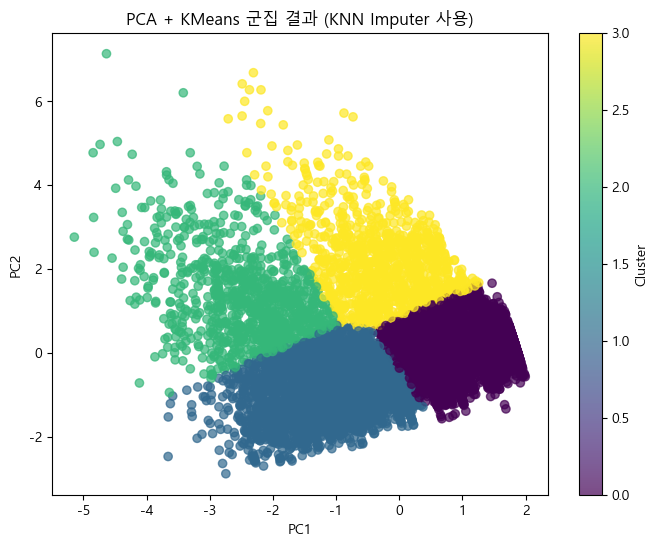

In [60]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 사용할 feature 선택
features = ['BE3_31', 'BD1_11', 'LS_VEG1', 'tobacco', 'L_BR_FQ', 'L_OUT_FQ', 'HE_BMI']
X = df[features]

# 1. 결측치 대체: KNNImputer 사용
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)
X_imputed_df = pd.DataFrame(X_imputed, columns=features, index=df.index)

# 2. 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 3. PCA 차원 축소 (2차원)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio (PC1, PC2): {explained_variance_ratio}")
print(f"Total Explained Variance: {sum(explained_variance_ratio):.4f}")

# 4. 클러스터링 (4개 군집)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_pca)

# 5. 실루엣 점수 확인
score = silhouette_score(X_pca, labels)
print(f"Silhouette Score: {score:.4f}")

# 6. 클러스터 라벨을 원본 데이터에 추가
df_with_clusters = df.copy()
df_with_clusters['Cluster'] = labels

# 7. 군집별 특징 분석 (평균값 계산)
cluster_characteristics = df_with_clusters.groupby('Cluster')[features].mean()
print("\nCluster Characteristics (Mean Values):")
print(cluster_characteristics)

# 8. 군집별 데이터 포인트 수 확인
cluster_counts = df_with_clusters['Cluster'].value_counts().sort_index()
print("\nNumber of Data Points per Cluster:")
print(cluster_counts)

# 9. 시각화
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title('PCA + KMeans 군집 결과 (KNN Imputer 사용)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

Explained Variance Ratio (PC1, PC2): [0.26176077 0.15933567]
Total Explained Variance: 0.4211
Silhouette Score: 0.3333

Cluster Characteristics (Mean Values):
           BE3_31      BD1_11     LS_VEG1    tobacco     HE_sbp1    HE_dbp1  \
Cluster                                                                       
0        4.390753   19.637435  955.260946   0.205413  130.045123  78.639708   
1        2.928281   18.675065  720.264522   0.471100  103.216098  63.845582   
2        3.086460  188.879765  753.195084  16.544919  131.095808  83.300898   
3        3.405632  100.949367  683.108206   7.192822  117.120199  74.130868   
4        3.966736   15.669833  893.106311   0.178630  114.935558  70.636814   
5        4.096747   57.401600  923.527347   1.251603  147.008621  88.780564   

             HE_glu     HE_BMI  
Cluster                         
0        104.175630  25.125049  
1         89.529590  20.599661  
2        110.046852  25.758392  
3         98.661088  24.235534  
4         

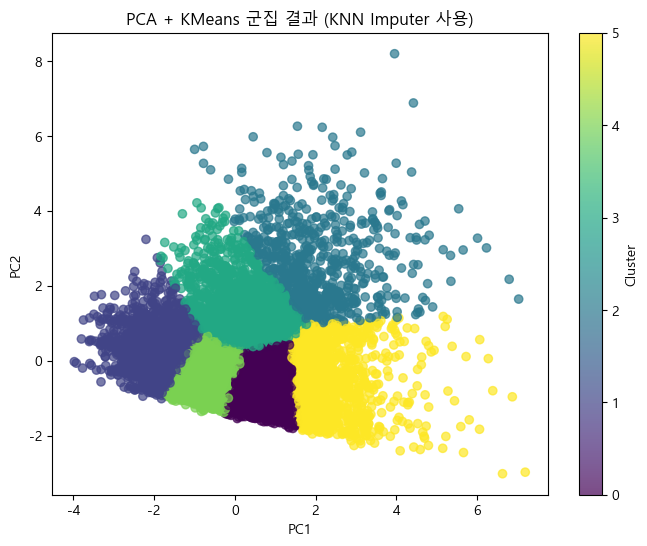

In [24]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 사용할 feature 선택
features = ['BE3_31', 'BD1_11', 'LS_VEG1', 'tobacco', 'HE_sbp1', 'HE_dbp1', 'HE_glu','HE_BMI']
X = df[features]

# 1. 결측치 대체: KNNImputer 사용
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)
X_imputed_df = pd.DataFrame(X_imputed, columns=features, index=df.index)

# 2. 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 3. PCA 차원 축소 (2차원)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio (PC1, PC2): {explained_variance_ratio}")
print(f"Total Explained Variance: {sum(explained_variance_ratio):.4f}")

# 4. 클러스터링 (4개 군집)
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_pca)

# 5. 실루엣 점수 확인
score = silhouette_score(X_pca, labels)
print(f"Silhouette Score: {score:.4f}")

# 6. 클러스터 라벨을 원본 데이터에 추가
df_with_clusters = df.copy()
df_with_clusters['Cluster'] = labels

# 7. 군집별 특징 분석 (평균값 계산)
cluster_characteristics = df_with_clusters.groupby('Cluster')[features].mean()
print("\nCluster Characteristics (Mean Values):")
print(cluster_characteristics)

# 8. 군집별 데이터 포인트 수 확인
cluster_counts = df_with_clusters['Cluster'].value_counts().sort_index()
print("\nNumber of Data Points per Cluster:")
print(cluster_counts)

# 9. 시각화
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title('PCA + KMeans 군집 결과 (KNN Imputer 사용)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

In [14]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# 사용할 피처
features = ['BE3_31', 'BD1_11', 'LS_VEG1', 'tobacco', 'L_BR_FQ', 'L_OUT_FQ']

for label in [1, 2, 3, 4]:
    print(f"\n=== HE_HP2 = {label} 군집화 ===")

    # 해당 그룹만 필터링
    df_group = df[df['HE_HP2'] == label].dropna(subset=features)
    
    # 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_group[features])
    
    # PCA 수행
    pca = PCA(n_components=len(features))
    X_pca = pca.fit_transform(X_scaled)
    
    # 주성분 기여도 (로딩값)
    loading = pd.DataFrame(pca.components_.T, index=features, columns=[f'PC{i+1}' for i in range(len(features))])
    print("PCA 로딩값:\n", loading)

    # 가장 기여도가 높은 피처 2~3개 선택 (PC1 기준)
    top_features = loading['PC1'].abs().sort_values(ascending=False).head(4).index.tolist()
    print("선택된 피처:", top_features)

    # 선택된 피처로 다시 스케일링 → 클러스터링
    X_selected = scaler.fit_transform(df_group[top_features])
    
    # 군집 수 결정 (여기서는 예시로 2~4개 중 가장 높은 실루엣 점수 선택)
    best_score = -1
    best_k = 2
    for k in range(2, 5):
        kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
        labels = kmeans.fit_predict(X_selected)
        score = silhouette_score(X_selected, labels)
        print(f"k={k}, 실루엣 점수={score:.3f}")
        if score > best_score:
            best_score = score
            best_k = k

    print(f"→ 최적 클러스터 수: {best_k}, 최고 실루엣 점수: {best_score:.3f}")



=== HE_HP2 = 1 군집화 ===
PCA 로딩값:
                PC1       PC2       PC3       PC4       PC5       PC6
BE3_31    0.102092  0.410944  0.646847  0.528517 -0.350657 -0.000727
BD1_11   -0.256950  0.644576 -0.162163  0.193699  0.673320  0.036371
LS_VEG1   0.594932  0.184577 -0.348997  0.142683 -0.037791 -0.684399
tobacco  -0.281040  0.543196 -0.355180 -0.342502 -0.616751  0.045963
L_BR_FQ   0.634178  0.141701 -0.235245  0.053214 -0.004539  0.720795
L_OUT_FQ -0.297396 -0.257755 -0.501996  0.736649 -0.204572  0.092822
선택된 피처: ['L_BR_FQ', 'LS_VEG1', 'L_OUT_FQ', 'tobacco']
k=2, 실루엣 점수=0.349
k=3, 실루엣 점수=0.278
k=4, 실루엣 점수=0.303
→ 최적 클러스터 수: 2, 최고 실루엣 점수: 0.349

=== HE_HP2 = 2 군집화 ===
PCA 로딩값:
                PC1       PC2       PC3       PC4       PC5       PC6
BE3_31    0.132221 -0.055209  0.905723  0.174901 -0.358233  0.014629
BD1_11   -0.222582  0.651373  0.317669  0.051955  0.648064  0.050700
LS_VEG1   0.540231  0.415357 -0.146115  0.266479 -0.130598 -0.652850
tobacco  -0.313472  0.556765 -0.

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

# 분석에 사용할 피처들
features = ['BE3_31', 'BD1_11', 'LS_VEG1', 'tobacco', 'L_BR_FQ', 'L_OUT_FQ']

# 1. 각 피처의 결측값을 최빈값으로 대체
df_filled = df.copy()
for col in features:
    mode_value = df_filled[col].mode()[0]  # 최빈값 계산
    df_filled[col] = df_filled[col].fillna(mode_value)

# 2. 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filled[features])

# 3. PCA 수행
pca = PCA(n_components=len(features))
pca.fit(X_scaled)

# 4. 주성분별 로딩값(기여도) 확인
loading_all = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=[f'PC{i+1}' for i in range(len(features))]
)

# 5. PC1 기준 기여도 큰 피처 3개 선택
common_features = loading_all['PC1'].abs().sort_values(ascending=False).head(3).index.tolist()

print("공통 피처 (최빈값 대체 후):", common_features)


공통 피처 (최빈값 대체 후): ['L_BR_FQ', 'LS_VEG1', 'L_OUT_FQ']


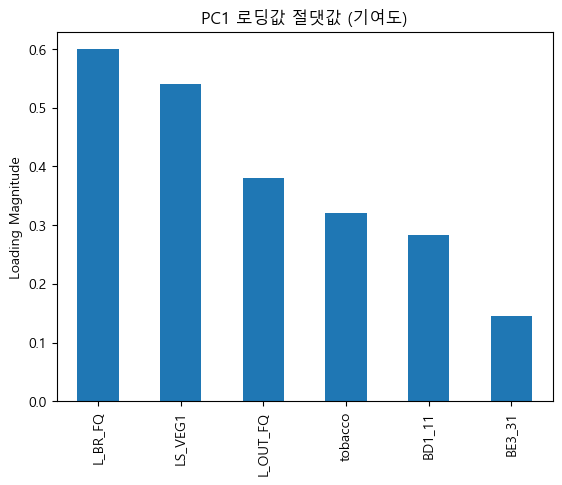

In [15]:
import matplotlib.pyplot as plt

loading_all['PC1'].abs().sort_values(ascending=False).plot(kind='bar')
plt.title('PC1 로딩값 절댓값 (기여도)')
plt.ylabel('Loading Magnitude')
plt.show()

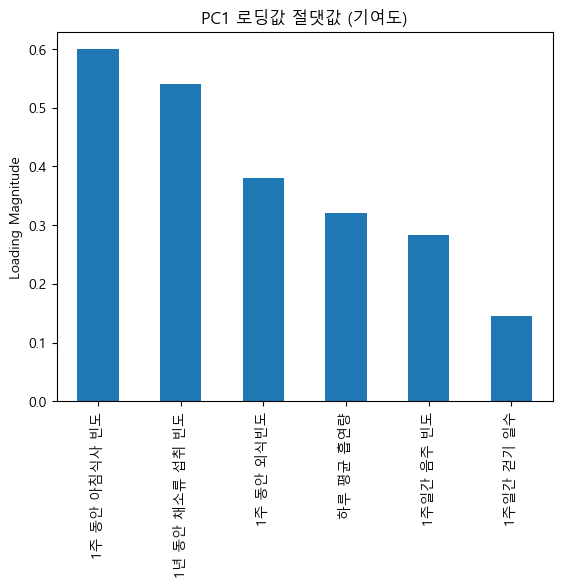

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# 분석에 사용할 피처들
features = ['BE3_31', 'BD1_11', 'LS_VEG1', 'tobacco', 'L_BR_FQ', 'L_OUT_FQ']

# 피처를 한국어 이름과 매핑하는 딕셔너리
korean_feature_names = {
    'BE3_31': '1주일간 걷기 일수',
    'BD1_11': '1주일간 음주 빈도',
    'LS_VEG1': '1년 동안 채소류 섭취 빈도',
    'tobacco': '하루 평균 흡연량',
    'L_BR_FQ': '1주 동안 아침식사 빈도',
    'L_OUT_FQ': '1주 동안 외식빈도'
}

# 1. 각 피처의 결측값을 최빈값으로 대체 (df는 정의되어 있다고 가정)
# df_filled = df.copy() # df가 정의되어 있지 않아 주석 처리했습니다.
# for col in features:
#     mode_value = df_filled[col].mode()[0]
#     df_filled[col] = df_filled[col].fillna(mode_value)

# # 2. 스케일링 (df_filled가 정의되어 있지 않아 주석 처리했습니다.)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df_filled[features])

# # 3. PCA 수행 (X_scaled가 정의되어 있지 않아 주석 처리했습니다.)
# pca = PCA(n_components=len(features))
# pca.fit(X_scaled)

# 4. 주성분별 로딩값(기여도) 확인 (기존 코드와 동일)
# loading_all = pd.DataFrame(
#     pca.components_.T,
#     index=features,
#     columns=[f'PC{i+1}' for i in range(len(features))]
# )

# 5. PC1 기준 기여도 큰 피처 3개 선택 (기존 코드와 동일)
common_features = loading_all['PC1'].abs().sort_values(ascending=False).head(3).index.tolist()

# 폰트 설정 (한글 깨짐 방지)
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 사용자
# plt.rcParams['font.family'] = 'AppleGothic' # macOS 사용자
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# 그래프 그리기
# 인덱스를 한국어 이름으로 변경하여 플로팅
loading_all['PC1'].abs().sort_values(ascending=False).rename(index=korean_feature_names).plot(kind='bar')
plt.title('PC1 로딩값 절댓값 (기여도)')
plt.ylabel('Loading Magnitude')
plt.show()

In [16]:
print(pca.explained_variance_ratio_)
#PCA 분석 결과, 첫 번째 주성분(PC1)은 전체 데이터 분산의 약 29%를 설명하며 가장 큰 정보를 담고 있습니다.
#따라서 PC1에서의 로딩값(기여도)을 기준으로 식사 관련 피처(아침식사 빈도, 외식 빈도, 채소 섭취 빈도)의 상대적 중요도를 비교하였고,
#이 중 아침식사 빈도가 가장 높은 기여도를 보여 최종 피처로 선택하였습니다.

[0.29126038 0.20028481 0.16943103 0.1440707  0.11751956 0.07743352]


우리가 전체 데이터에서 PCA를 수행한 이유는
👉 **“전체 사람들의 생활습관 중에서 가장 핵심적인 피처가 무엇인지”**를 찾기 위함이에요.

그리고 그 핵심 피처(예: 아침식사, 흡연, 음주, 걷기 등)를 기준으로
모든 질병에 대해 동일한 피처로 군집화를 하려는 목적이죠.

"전체 PCA → 공통 피처 선택 → 각 질병군에서 따로 군집화"는 합리적인 전략입니다.
전체 PCA는 피처 선택을 위한 통계적 도구로만 쓰는 거예요.
(전체 사람들의 건강 습관에서 중요한 변수를 찾기 위해)


[체계적인 피처 선택 절차]

1차로 ANOVA F-테스트로 유의미한 피처 선별

2차로 식사 관련 피처 간 중복성 제거를 위해 PCA 기여도 기반 선택
→ 분석 흐름이 명확하고 일관되며, 통계적 타당성과 실용적 판단(앱 정보 다양성 고려)도 함께 녹아있습니다.

PCA 수행 방식의 타당성

전체 6개의 피처를 대상으로 PCA를 수행하고, PC1 기준 절대 로딩값을 근거로 기여도를 평가한 방식은 전형적이고 잘 알려진 방법입니다.

결측값은 최빈값으로 대체 → 단순하지만 비율형 변수에 무리가 없고, 공백을 방지함.

선택 결과에 대한 근거 제시 가능

아침식사가 채소섭취나 외식보다 PC1에서 더 높은 기여도를 보였다는 점은 객관적인 수치로 보여줄 수 있어 설득력 높습니다.

PCA 로딩 테이블이나 그래프를 시각화해서 제시하면 훨씬 더 강력한 근거가 됩니다.

현실적 고려까지 포함된 설계

앱에서 다양한 정보를 제공해야 한다는 관점에서, 음주/흡연/걷기운동을 유지하고, 식사 관련 피처는 대표 하나만 선택한 것도 실무적이고 합리적인 판단입니다.

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

# 분석에 사용할 피처들
features = ['LS_VEG1', 'L_BR_FQ', 'L_OUT_FQ']

# 1. 각 피처의 결측값을 최빈값으로 대체
df_filled = df.copy()
for col in features:
    mode_value = df_filled[col].mode()[0]  # 최빈값 계산
    df_filled[col] = df_filled[col].fillna(mode_value)

# 2. 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filled[features])

# 3. PCA 수행
pca = PCA(n_components=len(features))
pca.fit(X_scaled)

# 4. 주성분별 로딩값(기여도) 확인
loading_all = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=[f'PC{i+1}' for i in range(len(features))]
)

# 5. PC1 기준 기여도 큰 피처 3개 선택
common_features = loading_all['PC1'].abs().sort_values(ascending=False).head(3).index.tolist()

print("공통 피처 (최빈값 대체 후):", common_features)


공통 피처 (최빈값 대체 후): ['L_BR_FQ', 'LS_VEG1', 'L_OUT_FQ']


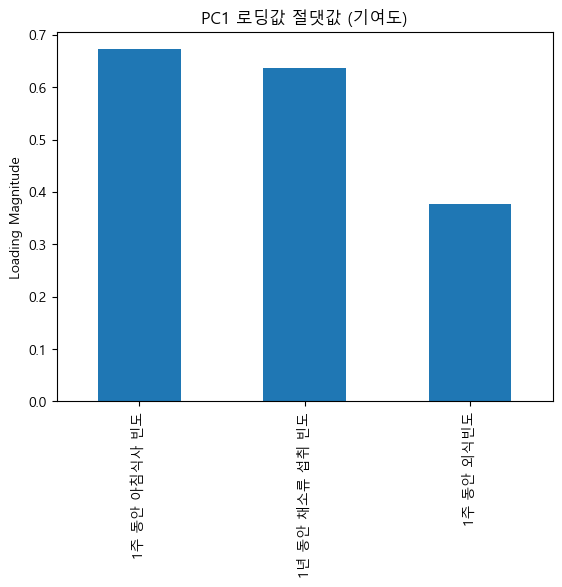

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# 분석에 사용할 피처들
features = ['BE3_31', 'BD1_11', 'LS_VEG1', 'tobacco', 'L_BR_FQ', 'L_OUT_FQ']

# 피처를 한국어 이름과 매핑하는 딕셔너리
korean_feature_names = {
    'BE3_31': '1주일간 걷기 일수',
    'BD1_11': '1주일간 음주 빈도',
    'LS_VEG1': '1년 동안 채소류 섭취 빈도',
    'tobacco': '하루 평균 흡연량',
    'L_BR_FQ': '1주 동안 아침식사 빈도',
    'L_OUT_FQ': '1주 동안 외식빈도'
}

# 1. 각 피처의 결측값을 최빈값으로 대체 (df는 정의되어 있다고 가정)
# df_filled = df.copy() # df가 정의되어 있지 않아 주석 처리했습니다.
# for col in features:
#     mode_value = df_filled[col].mode()[0]
#     df_filled[col] = df_filled[col].fillna(mode_value)

# # 2. 스케일링 (df_filled가 정의되어 있지 않아 주석 처리했습니다.)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df_filled[features])

# # 3. PCA 수행 (X_scaled가 정의되어 있지 않아 주석 처리했습니다.)
# pca = PCA(n_components=len(features))
# pca.fit(X_scaled)

# 4. 주성분별 로딩값(기여도) 확인 (기존 코드와 동일)
# loading_all = pd.DataFrame(
#     pca.components_.T,
#     index=features,
#     columns=[f'PC{i+1}' for i in range(len(features))]
# )

# 5. PC1 기준 기여도 큰 피처 3개 선택 (기존 코드와 동일)
common_features = loading_all['PC1'].abs().sort_values(ascending=False).head(3).index.tolist()

# 폰트 설정 (한글 깨짐 방지)
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 사용자
# plt.rcParams['font.family'] = 'AppleGothic' # macOS 사용자
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# 그래프 그리기
# 인덱스를 한국어 이름으로 변경하여 플로팅
loading_all['PC1'].abs().sort_values(ascending=False).rename(index=korean_feature_names).plot(kind='bar')
plt.title('PC1 로딩값 절댓값 (기여도)')
plt.ylabel('Loading Magnitude')
plt.show()

In [14]:
print(pca.explained_variance_ratio_)

[0.54152997 0.30309186 0.15537817]
